In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import numpy as np
import pandas as pd

import sys



from types import SimpleNamespace
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import accuracy_score

import time
from datetime import timedelta

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def load_txt_csv(path):
    # pandas jest lepszy dla GoogleDrive shortcutów
    df = pd.read_csv(path, header=None, delim_whitespace=True, engine='python')
    return df.to_numpy()

def load_location_data(path):
    acc_x = load_txt_csv(f'{path}/Acc_x.txt')
    acc_y = load_txt_csv(f'{path}/Acc_y.txt')
    acc_z = load_txt_csv(f'{path}/Acc_z.txt')
    gyr_x = load_txt_csv(f'{path}/Gyr_x.txt')
    gyr_y = load_txt_csv(f'{path}/Gyr_y.txt')
    gyr_z = load_txt_csv(f'{path}/Gyr_z.txt')
    mag_x = load_txt_csv(f'{path}/Mag_x.txt')
    mag_y = load_txt_csv(f'{path}/Mag_y.txt')
    mag_z = load_txt_csv(f'{path}/Mag_z.txt')

    data = np.stack([acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z, mag_x, mag_y, mag_z], axis=1)
    return data

In [3]:
hips = load_location_data("Data/SHL-2025-Train_Hips/train/Hips")

In [4]:
torso = load_location_data('Data/SHL-2025-Train_Torso/train/Torso')

In [5]:
bag = load_location_data('Data/SHL-2025-Train_Bag/train/Bag')

In [6]:
hand = load_location_data('Data/SHL-2025-Train_Hand/train/Hand')

In [7]:
X = np.concatenate([hips, torso, bag, hand], axis=0)
print(X.shape)  

(784288, 9, 500)


In [8]:
def load_label_file(path):
    df = pd.read_csv(path, header=None, sep='\s+', engine='python')
    return df[0].to_numpy()


In [9]:
labels_hips = load_label_file('Data/SHL-2025-Train_Hips/train/Hips/Label.txt')
labels_torso = load_label_file('Data/SHL-2025-Train_Torso/train/Torso/Label.txt')
labels_bag = load_label_file('Data/SHL-2025-Train_Bag/train/Bag/Label.txt')
labels_hand = load_label_file('Data/SHL-2025-Train_Hand/train/Hand/Label.txt')

In [10]:
y = np.concatenate([labels_hips, labels_torso, labels_bag, labels_hand])
print(y.shape)  
y -= 1 # aby klasy szly 0-7 nie 1-8 

(784288,)


In [11]:
test_data = load_location_data('Data/SHL-2025-Test/test')

In [12]:
val_bag = load_location_data("Data/SHL-2025-Validation/validation/Bag")
val_hips = load_location_data("Data/SHL-2025-Validation/validation/Hips")
val_hand = load_location_data("Data/SHL-2025-Validation/validation/Hand")
val_torso = load_location_data("Data/SHL-2025-Validation/validation/Torso")

In [13]:
val = np.concatenate([val_hips, val_torso, val_bag, val_hand], axis=0)
print(val.shape)  

(115156, 9, 500)


In [14]:
val_bag_label = load_label_file("Data/SHL-2025-Validation/validation/Bag/Label.txt")
val_hips_label = load_label_file("Data/SHL-2025-Validation/validation/Hips/Label.txt")
val_hand_label = load_label_file("Data/SHL-2025-Validation/validation/Hand/Label.txt")
val_torso_label = load_label_file("Data/SHL-2025-Validation/validation/Torso/Label.txt")

In [15]:
val_label = np.concatenate([val_hips_label,val_torso_label , val_bag_label, val_hand_label])
val_label -= 1 # aby klasy szly 0-7 nie 1-8
print(val_label.shape)  

(115156,)


X - wejscie treningowe (784288, 9, 500)


y - wejscie treningowe


val - wejscie walidacyjne (115156, 9, 500)


val_label - wejscie walidacyjne


test_data - dane testowe



Unikalne klasy: [0 1 2 3 4 5 6 7]
Rozkład klas:
Klasa 0: 97824 próbek
Klasa 1: 98216 próbek
Klasa 2: 33832 próbek
Klasa 3: 93880 próbek
Klasa 4: 126916 próbek
Klasa 5: 113276 próbek
Klasa 6: 125004 próbek
Klasa 7: 95340 próbek


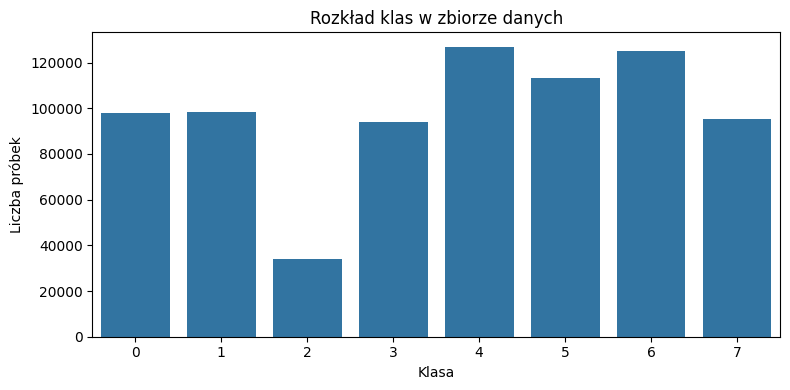

In [16]:
# Informacje o etykietach
print("Unikalne klasy:", np.unique(y))
print("Rozkład klas:")
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Klasa {cls}: {count} próbek")

# Wykres rozkładu klas
plt.figure(figsize=(8, 4))
sns.barplot(x=unique, y=counts)
plt.title("Rozkład klas w zbiorze danych")
plt.xlabel("Klasa")
plt.ylabel("Liczba próbek")
plt.tight_layout()
plt.show()

In [17]:
print(X.shape)  # (784288, 9, 500)
print(y.shape)  # (784288,)


(784288, 9, 500)
(784288,)


In [18]:
sys.path.append('./Time-Series-Library')
from models.TimesNet import Model as TimesNet

In [ ]:
# konfiguracja modelu TimesNet dla klasyfikacji
configs = SimpleNamespace(
    enc_in=9,        # liczba kanałów (cech)
    num_class=8,     # 8 klas aktywności
    c_out=8,         # liczba klas na wyjściu
    d_model=64,
    d_ff=128,
    e_layers=2,
    top_k=5,
    dropout=0.1,
    activation='gelu',
    seq_len=500,
    pred_len=1,
    patch_len=16,
    stride=8,
    task_name='classification',
    label_len=500, 
    num_kernels=6,
    embed='timeF',
    freq='h'
)

# wybór urządzenia
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

configs.device = device

# model
model = TimesNet(configs).to(device)


Using CUDA


Urządzenie: cuda
✅ Model zainicjalizowany

--- Epoka 1/30 ---


Epoka 1 [trening]:  67%|██████▋   | 8241/12255 [1:12:38<27:42,  2.41it/s, loss=1.1376]

⚠️ Batch 8241: NaN loss – pominięto


Epoka 1 [walidacja]: 100%|██████████| 1800/1800 [04:56<00:00,  6.07it/s]


✅ Epoka 1 zakończona | Loss: 12787.1946 | Val ACC: 0.4428 | Czas: 1:52:28


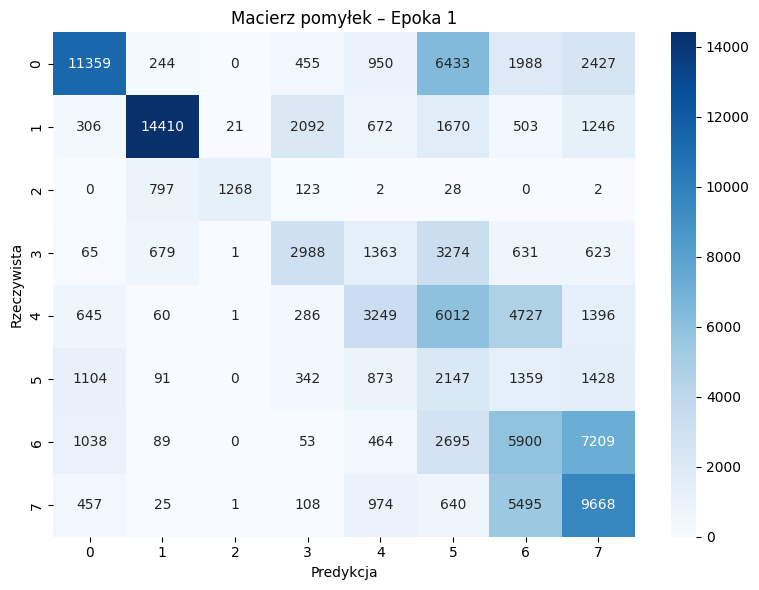

              precision    recall  f1-score   support

           0      0.759     0.476     0.585     23856
           1      0.879     0.689     0.772     20920
           2      0.981     0.571     0.722      2220
           3      0.463     0.310     0.372      9624
           4      0.380     0.198     0.261     16376
           5      0.094     0.292     0.142      7344
           6      0.286     0.338     0.310     17448
           7      0.403     0.557     0.467     17368

    accuracy                          0.443    115156
   macro avg      0.531     0.429     0.454    115156
weighted avg      0.539     0.443     0.470    115156

💾 Zapisano nowy najlepszy model: epoka 1, acc=0.4428

--- Epoka 2/30 ---


Epoka 2 [trening]:  63%|██████▎   | 7765/12255 [1:07:24<31:38,  2.37it/s, loss=0.7802]

⚠️ Batch 7765: NaN loss – pominięto


Epoka 2 [walidacja]: 100%|██████████| 1800/1800 [04:59<00:00,  6.01it/s]


✅ Epoka 2 zakończona | Loss: 9336.5098 | Val ACC: 0.4557 | Czas: 1:51:43


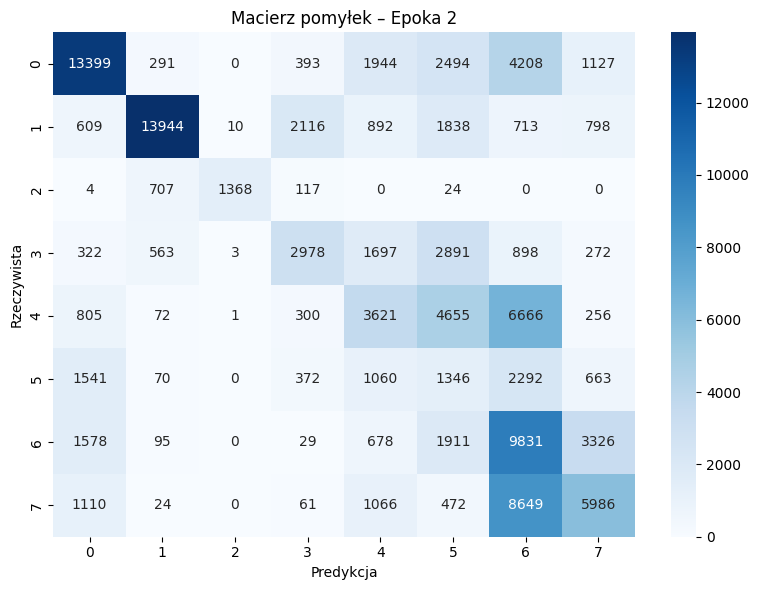

              precision    recall  f1-score   support

           0      0.692     0.562     0.620     23856
           1      0.884     0.667     0.760     20920
           2      0.990     0.616     0.760      2220
           3      0.468     0.309     0.372      9624
           4      0.330     0.221     0.265     16376
           5      0.086     0.183     0.117      7344
           6      0.296     0.563     0.388     17448
           7      0.482     0.345     0.402     17368

    accuracy                          0.456    115156
   macro avg      0.528     0.433     0.460    115156
weighted avg      0.532     0.456     0.477    115156

💾 Zapisano nowy najlepszy model: epoka 2, acc=0.4557

--- Epoka 3/30 ---


Epoka 3 [trening]:  92%|█████████▏| 11221/12255 [1:37:37<07:12,  2.39it/s, loss=0.6905]

⚠️ Batch 11221: NaN loss – pominięto


Epoka 3 [walidacja]: 100%|██████████| 1800/1800 [04:56<00:00,  6.08it/s]


✅ Epoka 3 zakończona | Loss: 8435.9789 | Val ACC: 0.4677 | Czas: 1:51:32


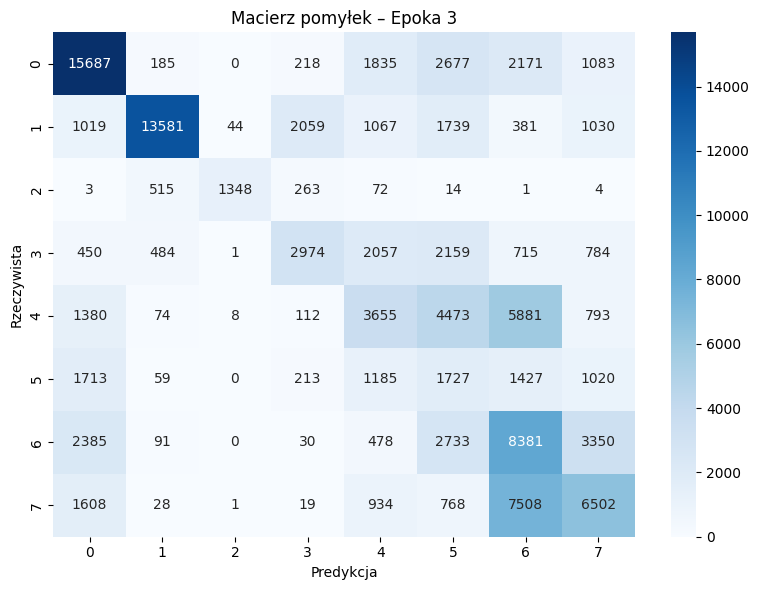

              precision    recall  f1-score   support

           0      0.647     0.658     0.652     23856
           1      0.904     0.649     0.756     20920
           2      0.961     0.607     0.744      2220
           3      0.505     0.309     0.383      9624
           4      0.324     0.223     0.264     16376
           5      0.106     0.235     0.146      7344
           6      0.317     0.480     0.382     17448
           7      0.446     0.374     0.407     17368

    accuracy                          0.468    115156
   macro avg      0.526     0.442     0.467    115156
weighted avg      0.527     0.468     0.485    115156

💾 Zapisano nowy najlepszy model: epoka 3, acc=0.4677

--- Epoka 4/30 ---


Epoka 4 [trening]:  43%|████▎     | 5289/12255 [45:57<48:16,  2.40it/s, loss=0.6510]  

⚠️ Batch 5289: NaN loss – pominięto


Epoka 4 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.09it/s]


✅ Epoka 4 zakończona | Loss: 7878.2174 | Val ACC: 0.4787 | Czas: 1:51:28


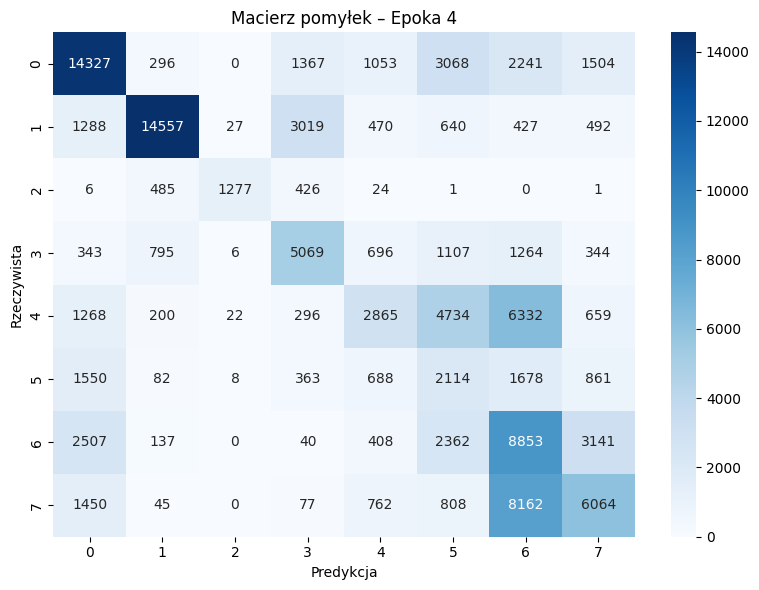

              precision    recall  f1-score   support

           0      0.630     0.601     0.615     23856
           1      0.877     0.696     0.776     20920
           2      0.953     0.575     0.717      2220
           3      0.476     0.527     0.500      9624
           4      0.411     0.175     0.245     16376
           5      0.143     0.288     0.191      7344
           6      0.306     0.507     0.382     17448
           7      0.464     0.349     0.399     17368

    accuracy                          0.479    115156
   macro avg      0.532     0.465     0.478    115156
weighted avg      0.532     0.479     0.489    115156

💾 Zapisano nowy najlepszy model: epoka 4, acc=0.4787

--- Epoka 5/30 ---


Epoka 5 [trening]:  93%|█████████▎| 11351/12255 [1:38:46<06:18,  2.39it/s, loss=0.6041]

⚠️ Batch 11351: NaN loss – pominięto


Epoka 5 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.09it/s]


✅ Epoka 5 zakończona | Loss: 7383.8186 | Val ACC: 0.4897 | Czas: 1:51:34


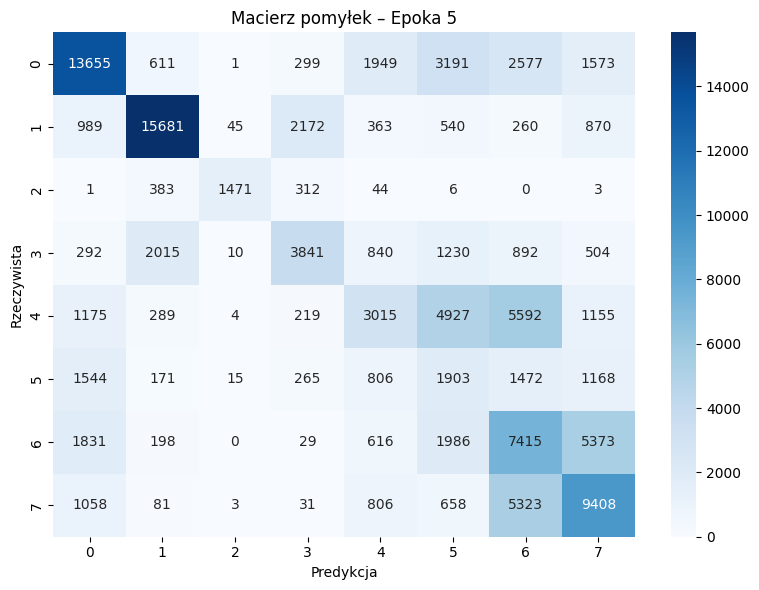

              precision    recall  f1-score   support

           0      0.665     0.572     0.615     23856
           1      0.807     0.750     0.777     20920
           2      0.950     0.663     0.781      2220
           3      0.536     0.399     0.457      9624
           4      0.357     0.184     0.243     16376
           5      0.132     0.259     0.175      7344
           6      0.315     0.425     0.362     17448
           7      0.469     0.542     0.503     17368

    accuracy                          0.490    115156
   macro avg      0.529     0.474     0.489    115156
weighted avg      0.525     0.490     0.498    115156

💾 Zapisano nowy najlepszy model: epoka 5, acc=0.4897

--- Epoka 6/30 ---


Epoka 6 [trening]:  45%|████▍     | 5460/12255 [47:35<47:26,  2.39it/s, loss=0.5770]  

⚠️ Batch 5460: NaN loss – pominięto


Epoka 6 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 6 zakończona | Loss: 6998.5328 | Val ACC: 0.4856 | Czas: 1:51:46


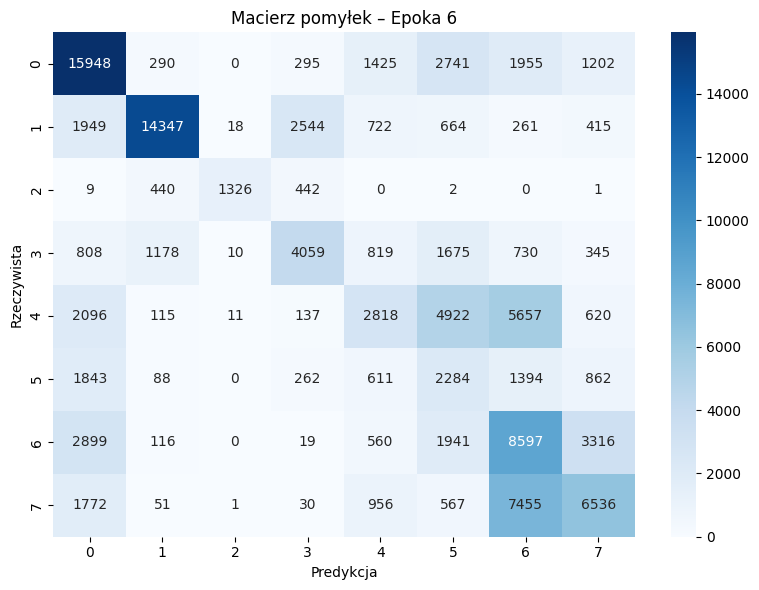

              precision    recall  f1-score   support

           0      0.584     0.669     0.623     23856
           1      0.863     0.686     0.764     20920
           2      0.971     0.597     0.740      2220
           3      0.521     0.422     0.466      9624
           4      0.356     0.172     0.232     16376
           5      0.154     0.311     0.206      7344
           6      0.330     0.493     0.395     17448
           7      0.492     0.376     0.426     17368

    accuracy                          0.486    115156
   macro avg      0.534     0.466     0.482    115156
weighted avg      0.525     0.486     0.492    115156


--- Epoka 7/30 ---


Epoka 7 [trening]:  63%|██████▎   | 7660/12255 [1:06:49<32:01,  2.39it/s, loss=0.5473]

⚠️ Batch 7660: NaN loss – pominięto


Epoka 7 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 7 zakończona | Loss: 6679.3820 | Val ACC: 0.4876 | Czas: 1:51:50


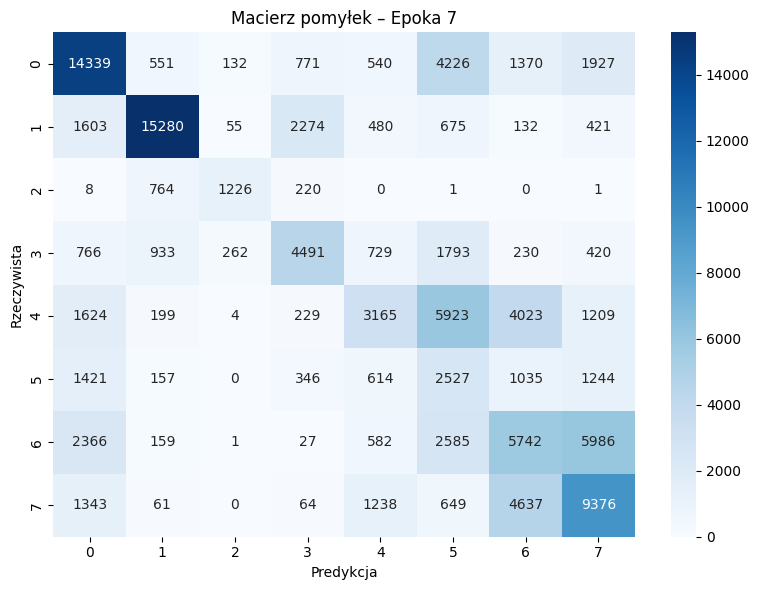

              precision    recall  f1-score   support

           0      0.611     0.601     0.606     23856
           1      0.844     0.730     0.783     20920
           2      0.730     0.552     0.629      2220
           3      0.533     0.467     0.498      9624
           4      0.431     0.193     0.267     16376
           5      0.137     0.344     0.196      7344
           6      0.334     0.329     0.332     17448
           7      0.455     0.540     0.494     17368

    accuracy                          0.488    115156
   macro avg      0.510     0.470     0.476    115156
weighted avg      0.528     0.488     0.497    115156


--- Epoka 8/30 ---


Epoka 8 [trening]:  28%|██▊       | 3407/12255 [29:45<1:01:30,  2.40it/s, loss=0.5256]

⚠️ Batch 3407: NaN loss – pominięto


Epoka 8 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.10it/s]


✅ Epoka 8 zakończona | Loss: 6388.5121 | Val ACC: 0.4849 | Czas: 1:52:01


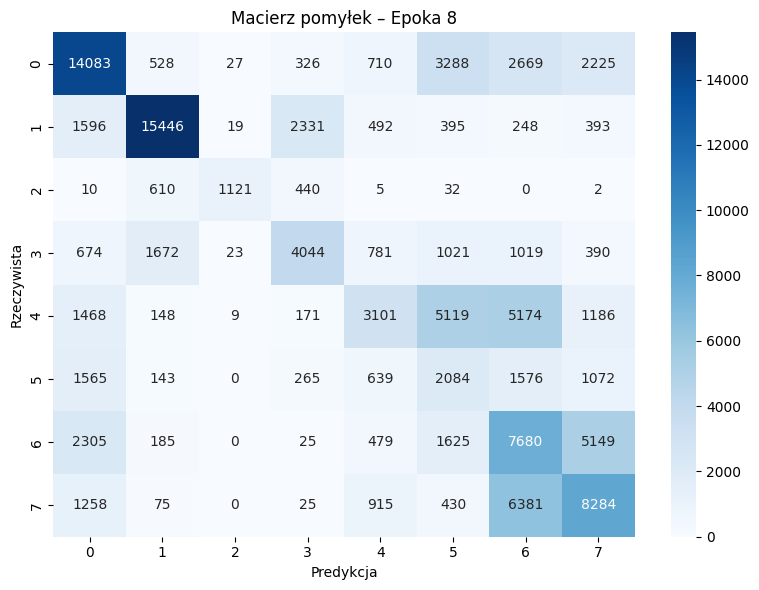

              precision    recall  f1-score   support

           0      0.613     0.590     0.602     23856
           1      0.821     0.738     0.778     20920
           2      0.935     0.505     0.656      2220
           3      0.530     0.420     0.469      9624
           4      0.435     0.189     0.264     16376
           5      0.149     0.284     0.195      7344
           6      0.310     0.440     0.364     17448
           7      0.443     0.477     0.459     17368

    accuracy                          0.485    115156
   macro avg      0.530     0.456     0.473    115156
weighted avg      0.524     0.485     0.492    115156


--- Epoka 9/30 ---


Epoka 9 [trening]:  96%|█████████▌| 11781/12255 [1:42:59<03:18,  2.39it/s, loss=0.4937]

⚠️ Batch 11781: NaN loss – pominięto


Epoka 9 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 9 zakończona | Loss: 6045.4800 | Val ACC: 0.4840 | Czas: 1:52:02


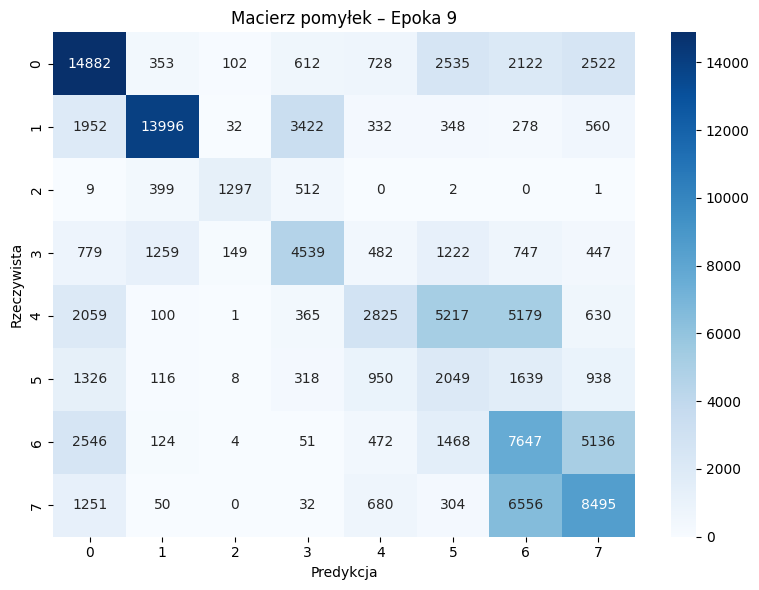

              precision    recall  f1-score   support

           0      0.600     0.624     0.612     23856
           1      0.854     0.669     0.750     20920
           2      0.814     0.584     0.680      2220
           3      0.461     0.472     0.466      9624
           4      0.437     0.173     0.247     16376
           5      0.156     0.279     0.200      7344
           6      0.316     0.438     0.368     17448
           7      0.454     0.489     0.471     17368

    accuracy                          0.484    115156
   macro avg      0.511     0.466     0.474    115156
weighted avg      0.522     0.484     0.490    115156


--- Epoka 10/30 ---


Epoka 10 [trening]:  59%|█████▉    | 7212/12255 [1:02:59<35:06,  2.39it/s, loss=0.4735]

⚠️ Batch 7212: NaN loss – pominięto


Epoka 10 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 10 zakończona | Loss: 5778.5115 | Val ACC: 0.4908 | Czas: 1:52:00


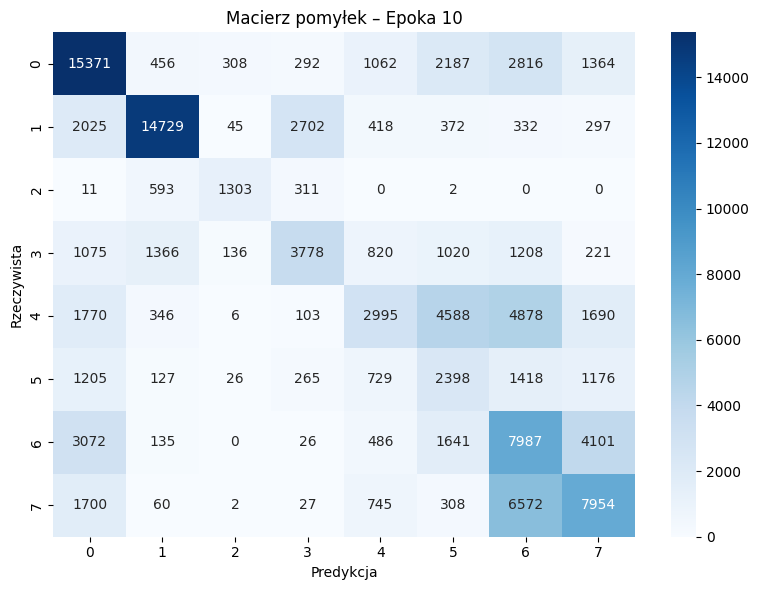

              precision    recall  f1-score   support

           0      0.586     0.644     0.614     23856
           1      0.827     0.704     0.761     20920
           2      0.714     0.587     0.644      2220
           3      0.503     0.393     0.441      9624
           4      0.413     0.183     0.253     16376
           5      0.192     0.327     0.241      7344
           6      0.317     0.458     0.374     17448
           7      0.473     0.458     0.466     17368

    accuracy                          0.491    115156
   macro avg      0.503     0.469     0.474    115156
weighted avg      0.518     0.491     0.493    115156

💾 Zapisano nowy najlepszy model: epoka 10, acc=0.4908

--- Epoka 11/30 ---


Epoka 11 [trening]:  82%|████████▏ | 10008/12255 [1:27:26<15:35,  2.40it/s, loss=0.4542]

⚠️ Batch 10008: NaN loss – pominięto


Epoka 11 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.09it/s]


✅ Epoka 11 zakończona | Loss: 5558.7583 | Val ACC: 0.5246 | Czas: 1:52:00


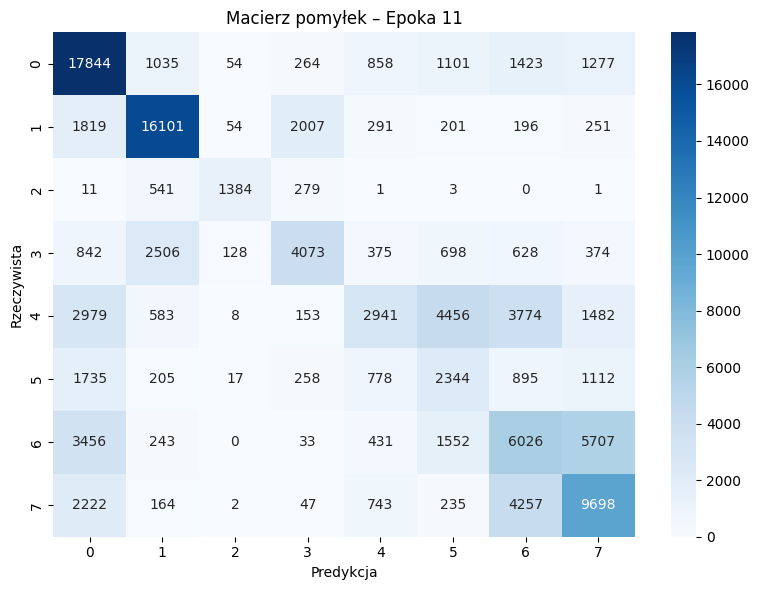

              precision    recall  f1-score   support

           0      0.577     0.748     0.652     23856
           1      0.753     0.770     0.761     20920
           2      0.840     0.623     0.716      2220
           3      0.573     0.423     0.487      9624
           4      0.458     0.180     0.258     16376
           5      0.221     0.319     0.261      7344
           6      0.350     0.345     0.348     17448
           7      0.487     0.558     0.520     17368

    accuracy                          0.525    115156
   macro avg      0.533     0.496     0.500    115156
weighted avg      0.526     0.525     0.512    115156

💾 Zapisano nowy najlepszy model: epoka 11, acc=0.5246

--- Epoka 12/30 ---


Epoka 12 [trening]:  22%|██▏       | 2754/12255 [24:04<1:06:31,  2.38it/s, loss=0.4424]

⚠️ Batch 2754: NaN loss – pominięto


Epoka 12 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.11it/s]


✅ Epoka 12 zakończona | Loss: 5395.0719 | Val ACC: 0.5329 | Czas: 1:51:58


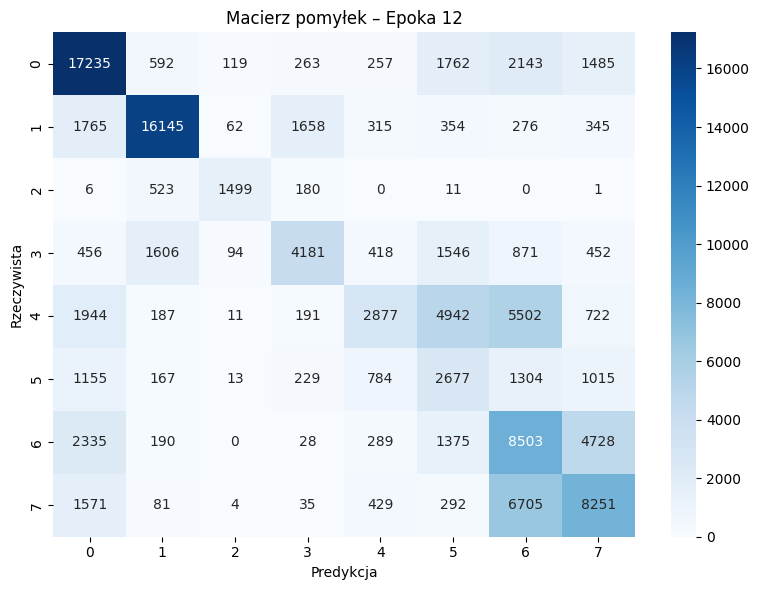

              precision    recall  f1-score   support

           0      0.651     0.722     0.685     23856
           1      0.828     0.772     0.799     20920
           2      0.832     0.675     0.745      2220
           3      0.618     0.434     0.510      9624
           4      0.536     0.176     0.265     16376
           5      0.207     0.365     0.264      7344
           6      0.336     0.487     0.398     17448
           7      0.485     0.475     0.480     17368

    accuracy                          0.533    115156
   macro avg      0.562     0.513     0.518    115156
weighted avg      0.567     0.533     0.531    115156

💾 Zapisano nowy najlepszy model: epoka 12, acc=0.5329

--- Epoka 13/30 ---


Epoka 13 [trening]:   4%|▍         | 492/12255 [04:17<1:21:31,  2.40it/s, loss=0.4193]

⚠️ Batch 492: NaN loss – pominięto


Epoka 13 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 13 zakończona | Loss: 5251.6444 | Val ACC: 0.5121 | Czas: 1:51:59


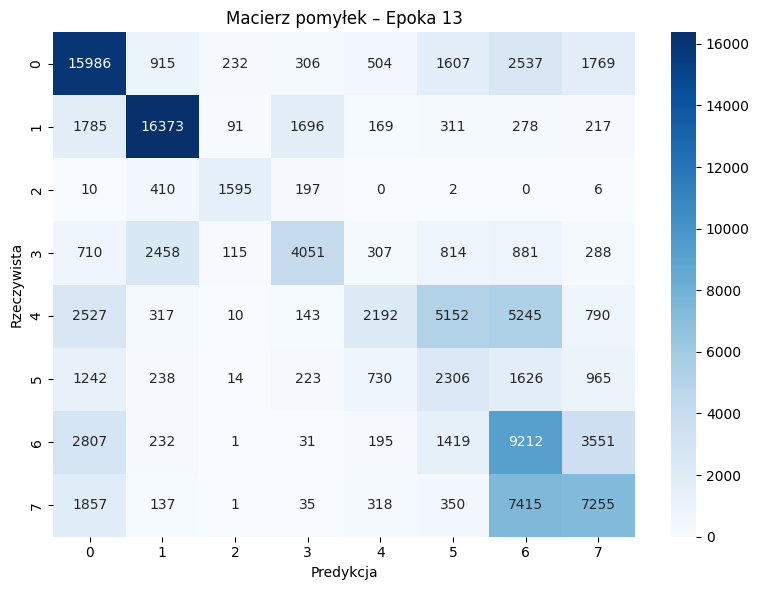

              precision    recall  f1-score   support

           0      0.594     0.670     0.630     23856
           1      0.777     0.783     0.780     20920
           2      0.775     0.718     0.746      2220
           3      0.606     0.421     0.497      9624
           4      0.496     0.134     0.211     16376
           5      0.193     0.314     0.239      7344
           6      0.339     0.528     0.413     17448
           7      0.489     0.418     0.450     17368

    accuracy                          0.512    115156
   macro avg      0.534     0.498     0.496    115156
weighted avg      0.538     0.512     0.504    115156


--- Epoka 14/30 ---


Epoka 14 [trening]:  84%|████████▎ | 10234/12255 [1:29:20<13:56,  2.42it/s, loss=0.4197]

⚠️ Batch 10234: NaN loss – pominięto


Epoka 14 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 14 zakończona | Loss: 5133.8201 | Val ACC: 0.5097 | Czas: 1:51:54


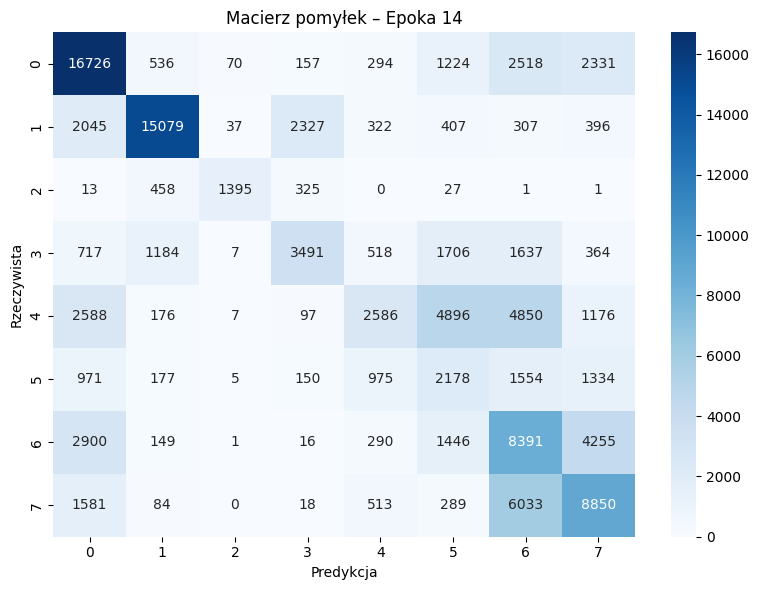

              precision    recall  f1-score   support

           0      0.607     0.701     0.651     23856
           1      0.845     0.721     0.778     20920
           2      0.917     0.628     0.746      2220
           3      0.530     0.363     0.431      9624
           4      0.470     0.158     0.236     16376
           5      0.179     0.297     0.223      7344
           6      0.332     0.481     0.393     17448
           7      0.473     0.510     0.491     17368

    accuracy                          0.510    115156
   macro avg      0.544     0.482     0.494    115156
weighted avg      0.541     0.510     0.508    115156


--- Epoka 15/30 ---


Epoka 15 [trening]:  85%|████████▌ | 10428/12255 [1:31:03<12:37,  2.41it/s, loss=0.4089]

⚠️ Batch 10428: NaN loss – pominięto


Epoka 15 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 15 zakończona | Loss: 5013.4831 | Val ACC: 0.5306 | Czas: 1:51:56


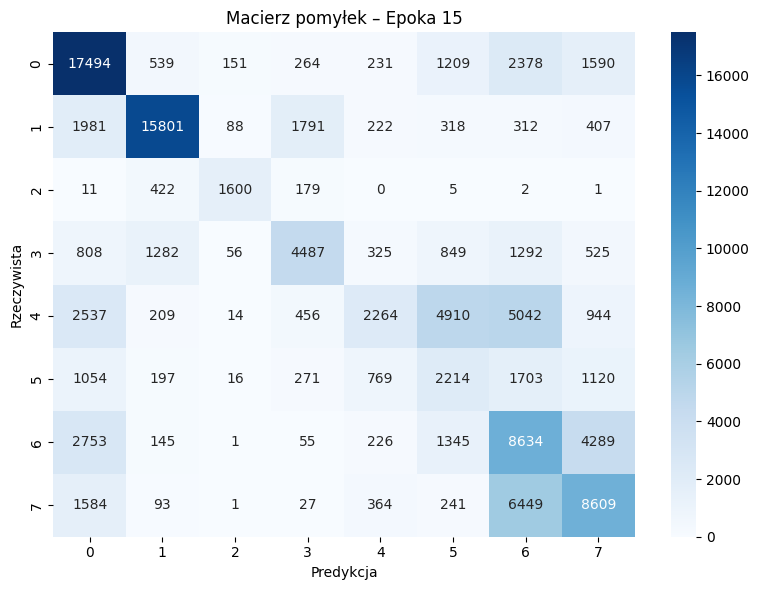

              precision    recall  f1-score   support

           0      0.620     0.733     0.672     23856
           1      0.846     0.755     0.798     20920
           2      0.830     0.721     0.772      2220
           3      0.596     0.466     0.523      9624
           4      0.514     0.138     0.218     16376
           5      0.200     0.301     0.240      7344
           6      0.334     0.495     0.399     17448
           7      0.492     0.496     0.494     17368

    accuracy                          0.531    115156
   macro avg      0.554     0.513     0.514    115156
weighted avg      0.559     0.531     0.524    115156


--- Epoka 16/30 ---


Epoka 16 [trening]:   1%|          | 104/12255 [00:54<1:24:36,  2.39it/s, loss=0.3906]

⚠️ Batch 104: NaN loss – pominięto


Epoka 16 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 16 zakończona | Loss: 4909.2829 | Val ACC: 0.5183 | Czas: 1:52:00


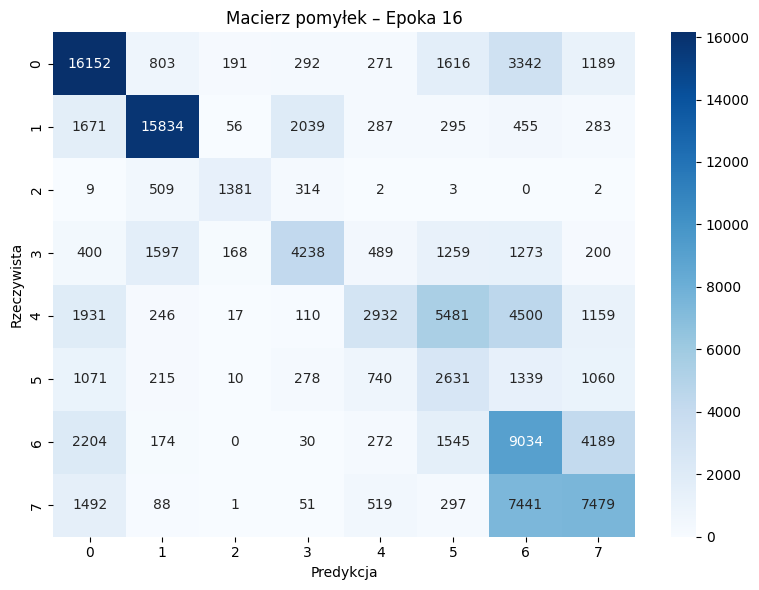

              precision    recall  f1-score   support

           0      0.648     0.677     0.662     23856
           1      0.813     0.757     0.784     20920
           2      0.757     0.622     0.683      2220
           3      0.576     0.440     0.499      9624
           4      0.532     0.179     0.268     16376
           5      0.200     0.358     0.257      7344
           6      0.330     0.518     0.403     17448
           7      0.481     0.431     0.454     17368

    accuracy                          0.518    115156
   macro avg      0.542     0.498     0.501    115156
weighted avg      0.556     0.518     0.519    115156


--- Epoka 17/30 ---


Epoka 17 [trening]:  84%|████████▎ | 10237/12255 [1:29:28<14:06,  2.38it/s, loss=0.3937]

⚠️ Batch 10237: NaN loss – pominięto


Epoka 17 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.10it/s]


✅ Epoka 17 zakończona | Loss: 4834.2204 | Val ACC: 0.5300 | Czas: 1:52:00


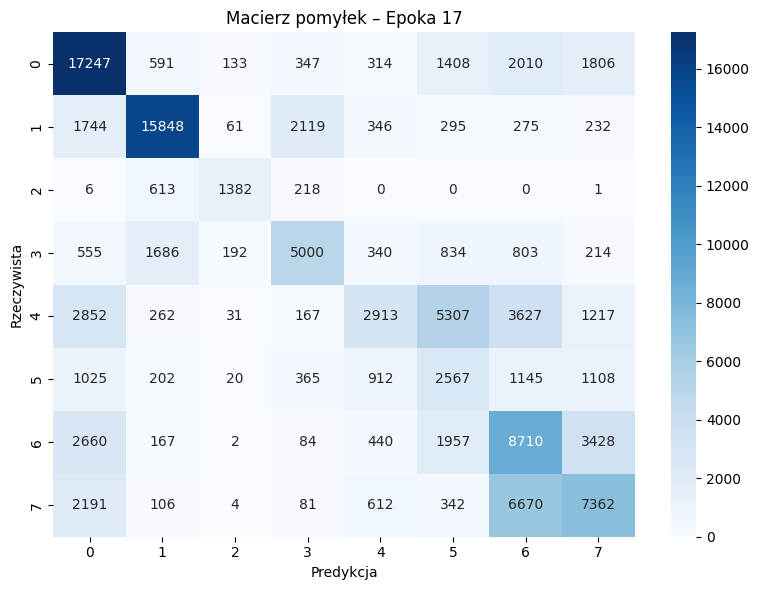

              precision    recall  f1-score   support

           0      0.610     0.723     0.662     23856
           1      0.814     0.758     0.785     20920
           2      0.757     0.623     0.683      2220
           3      0.597     0.520     0.555      9624
           4      0.496     0.178     0.262     16376
           5      0.202     0.350     0.256      7344
           6      0.375     0.499     0.428     17448
           7      0.479     0.424     0.450     17368

    accuracy                          0.530    115156
   macro avg      0.541     0.509     0.510    115156
weighted avg      0.551     0.530     0.525    115156


--- Epoka 18/30 ---


Epoka 18 [trening]:  12%|█▏        | 1531/12255 [13:21<1:14:30,  2.40it/s, loss=0.3823]

⚠️ Batch 1531: NaN loss – pominięto


Epoka 18 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.10it/s]


✅ Epoka 18 zakończona | Loss: 4751.4594 | Val ACC: 0.5217 | Czas: 1:51:59


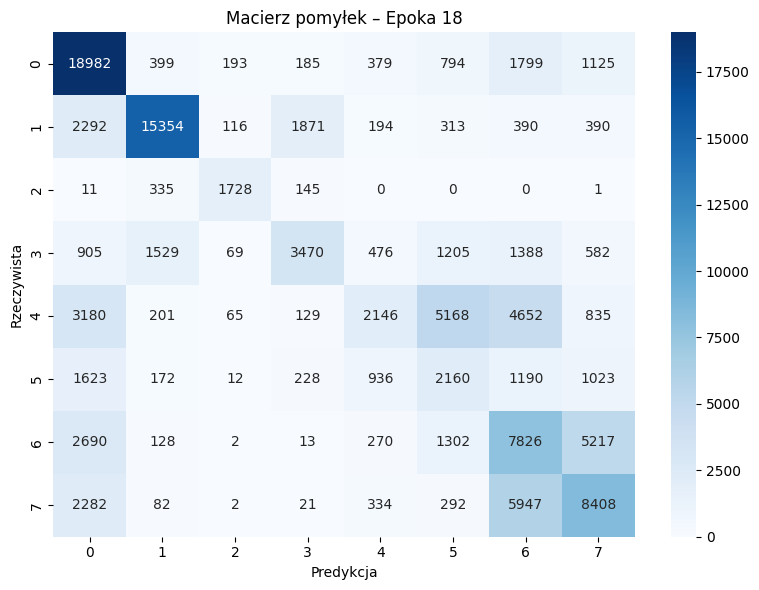

              precision    recall  f1-score   support

           0      0.594     0.796     0.680     23856
           1      0.844     0.734     0.785     20920
           2      0.790     0.778     0.784      2220
           3      0.572     0.361     0.442      9624
           4      0.453     0.131     0.203     16376
           5      0.192     0.294     0.233      7344
           6      0.337     0.449     0.385     17448
           7      0.478     0.484     0.481     17368

    accuracy                          0.522    115156
   macro avg      0.533     0.503     0.499    115156
weighted avg      0.539     0.522     0.510    115156


--- Epoka 19/30 ---


Epoka 19 [trening]:  45%|████▍     | 5490/12255 [47:56<46:58,  2.40it/s, loss=0.3802]  

⚠️ Batch 5490: NaN loss – pominięto


Epoka 19 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.10it/s]


✅ Epoka 19 zakończona | Loss: 4676.5176 | Val ACC: 0.5180 | Czas: 1:51:57


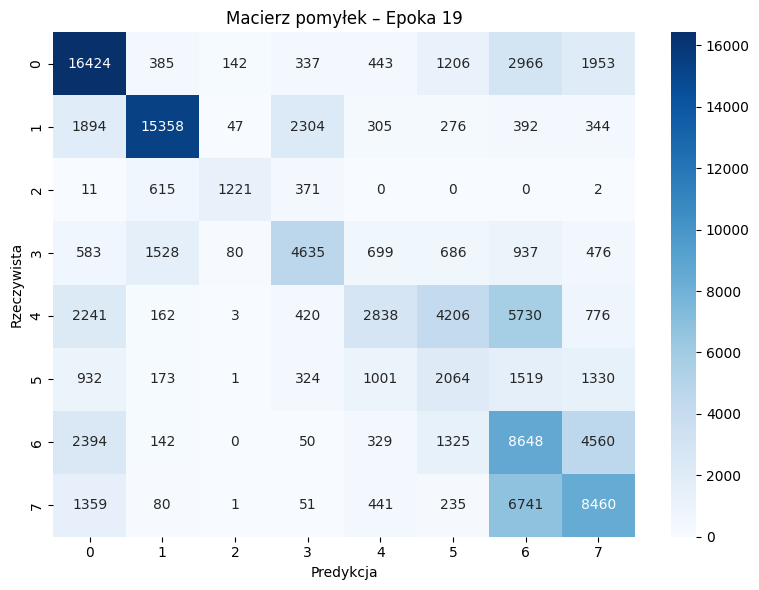

              precision    recall  f1-score   support

           0      0.636     0.688     0.661     23856
           1      0.833     0.734     0.780     20920
           2      0.817     0.550     0.657      2220
           3      0.546     0.482     0.512      9624
           4      0.469     0.173     0.253     16376
           5      0.206     0.281     0.238      7344
           6      0.321     0.496     0.390     17448
           7      0.473     0.487     0.480     17368

    accuracy                          0.518    115156
   macro avg      0.537     0.486     0.496    115156
weighted avg      0.544     0.518     0.517    115156


--- Epoka 20/30 ---


Epoka 20 [trening]:   9%|▊         | 1049/12255 [09:08<1:17:02,  2.42it/s, loss=0.3747]

⚠️ Batch 1049: NaN loss – pominięto


Epoka 20 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 20 zakończona | Loss: 4602.9983 | Val ACC: 0.5129 | Czas: 1:51:57


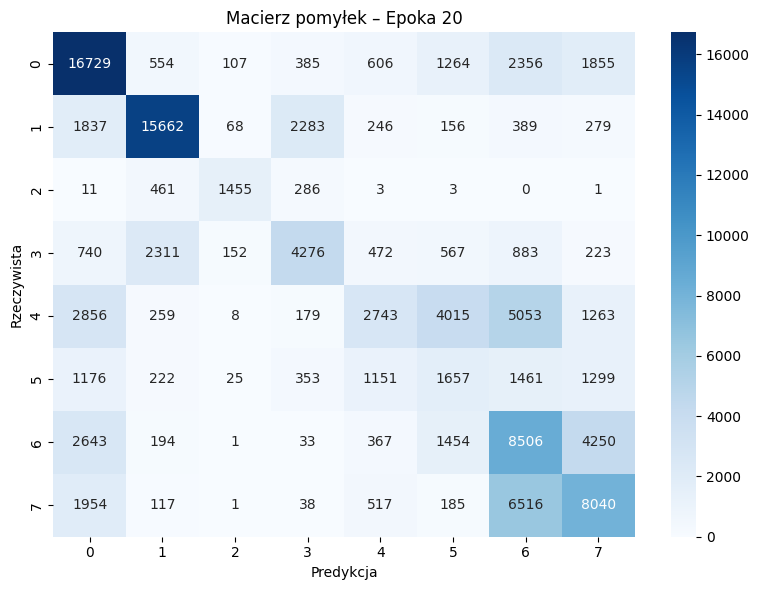

              precision    recall  f1-score   support

           0      0.599     0.701     0.646     23856
           1      0.792     0.749     0.770     20920
           2      0.801     0.655     0.721      2220
           3      0.546     0.444     0.490      9624
           4      0.449     0.168     0.244     16376
           5      0.178     0.226     0.199      7344
           6      0.338     0.488     0.399     17448
           7      0.467     0.463     0.465     17368

    accuracy                          0.513    115156
   macro avg      0.521     0.487     0.492    115156
weighted avg      0.526     0.513     0.506    115156


--- Epoka 21/30 ---


Epoka 21 [trening]:  76%|███████▋  | 9366/12255 [1:21:44<19:58,  2.41it/s, loss=0.3707]

⚠️ Batch 9366: NaN loss – pominięto


Epoka 21 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.10it/s]


✅ Epoka 21 zakończona | Loss: 4540.0710 | Val ACC: 0.5166 | Czas: 1:51:52


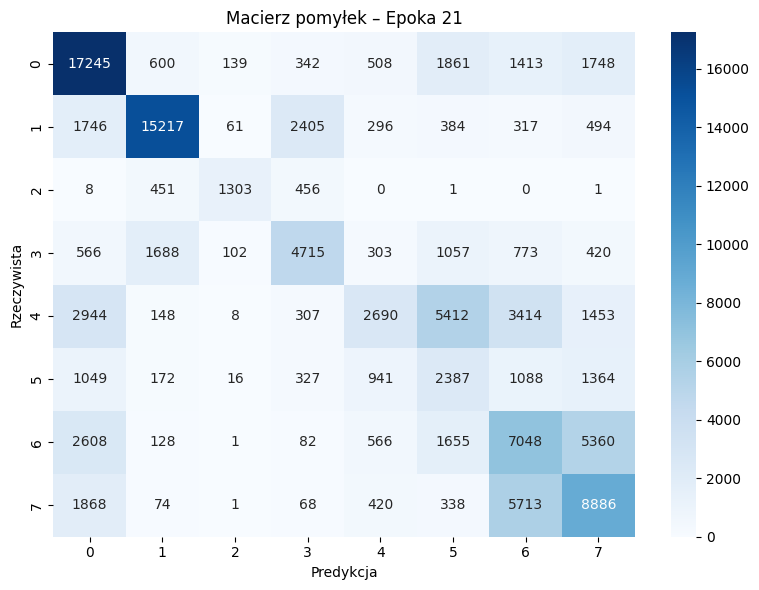

              precision    recall  f1-score   support

           0      0.615     0.723     0.665     23856
           1      0.824     0.727     0.772     20920
           2      0.799     0.587     0.677      2220
           3      0.542     0.490     0.515      9624
           4      0.470     0.164     0.243     16376
           5      0.182     0.325     0.234      7344
           6      0.357     0.404     0.379     17448
           7      0.450     0.512     0.479     17368

    accuracy                          0.517    115156
   macro avg      0.530     0.491     0.495    115156
weighted avg      0.538     0.517     0.513    115156


--- Epoka 22/30 ---


Epoka 22 [trening]:  65%|██████▍   | 7945/12255 [1:09:22<30:09,  2.38it/s, loss=0.3653]

⚠️ Batch 7945: NaN loss – pominięto


Epoka 22 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.11it/s]


✅ Epoka 22 zakończona | Loss: 4487.9897 | Val ACC: 0.5275 | Czas: 1:51:55


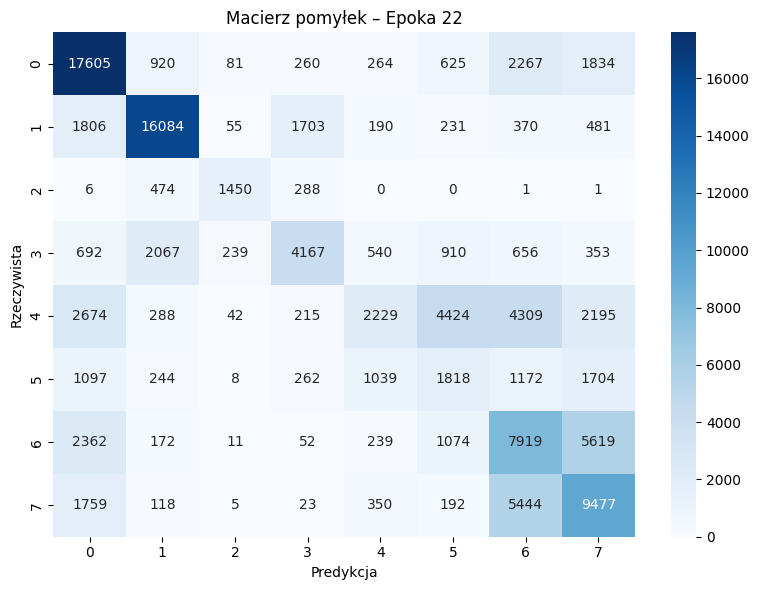

              precision    recall  f1-score   support

           0      0.629     0.738     0.679     23856
           1      0.790     0.769     0.779     20920
           2      0.767     0.653     0.705      2220
           3      0.598     0.433     0.502      9624
           4      0.459     0.136     0.210     16376
           5      0.196     0.248     0.219      7344
           6      0.358     0.454     0.400     17448
           7      0.437     0.546     0.486     17368

    accuracy                          0.528    115156
   macro avg      0.529     0.497     0.498    115156
weighted avg      0.536     0.528     0.515    115156


--- Epoka 23/30 ---


Epoka 23 [trening]:  91%|█████████▏| 11207/12255 [1:37:53<07:19,  2.39it/s, loss=0.3605]

⚠️ Batch 11207: NaN loss – pominięto


Epoka 23 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.10it/s]


✅ Epoka 23 zakończona | Loss: 4426.3277 | Val ACC: 0.5159 | Czas: 1:51:57


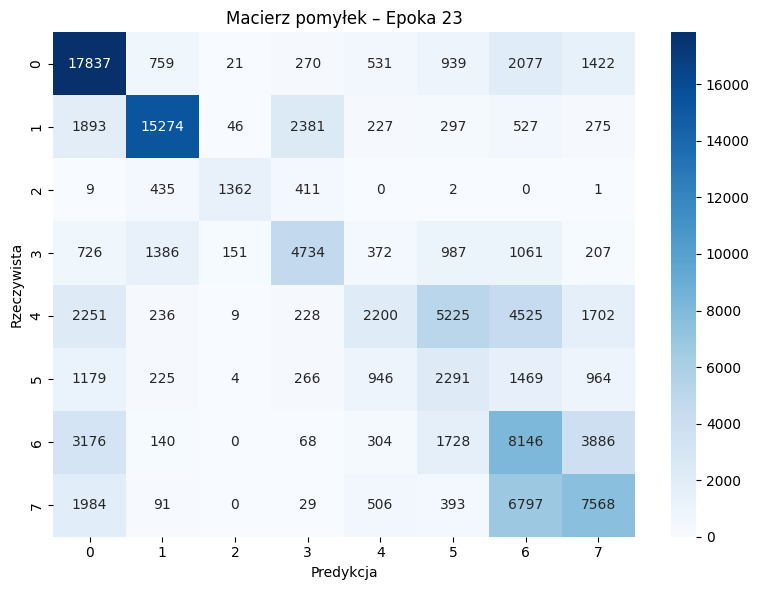

              precision    recall  f1-score   support

           0      0.614     0.748     0.674     23856
           1      0.824     0.730     0.774     20920
           2      0.855     0.614     0.714      2220
           3      0.564     0.492     0.526      9624
           4      0.433     0.134     0.205     16376
           5      0.193     0.312     0.239      7344
           6      0.331     0.467     0.387     17448
           7      0.472     0.436     0.453     17368

    accuracy                          0.516    115156
   macro avg      0.536     0.492     0.497    115156
weighted avg      0.536     0.516     0.509    115156


--- Epoka 24/30 ---


Epoka 24 [trening]:  84%|████████▍ | 10317/12255 [1:30:08<13:33,  2.38it/s, loss=0.3561]

⚠️ Batch 10317: NaN loss – pominięto


Epoka 24 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.10it/s]


✅ Epoka 24 zakończona | Loss: 4371.1280 | Val ACC: 0.5145 | Czas: 1:51:59


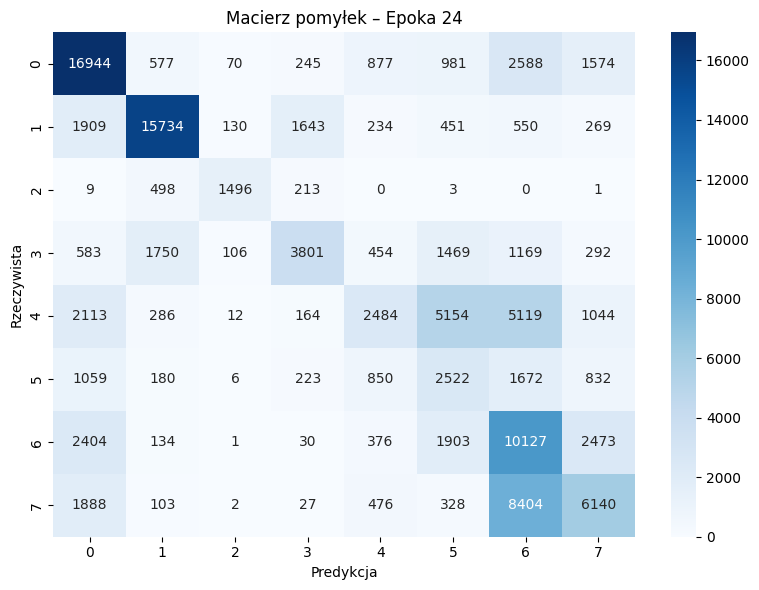

              precision    recall  f1-score   support

           0      0.630     0.710     0.668     23856
           1      0.817     0.752     0.783     20920
           2      0.821     0.674     0.740      2220
           3      0.599     0.395     0.476      9624
           4      0.432     0.152     0.225     16376
           5      0.197     0.343     0.250      7344
           6      0.342     0.580     0.430     17448
           7      0.486     0.354     0.409     17368

    accuracy                          0.515    115156
   macro avg      0.540     0.495     0.498    115156
weighted avg      0.544     0.515     0.509    115156


--- Epoka 25/30 ---


Epoka 25 [trening]:  35%|███▍      | 4274/12255 [37:21<55:45,  2.39it/s, loss=0.3491]  

⚠️ Batch 4274: NaN loss – pominięto


Epoka 25 [walidacja]: 100%|██████████| 1800/1800 [04:50<00:00,  6.19it/s]


✅ Epoka 25 zakończona | Loss: 4324.6662 | Val ACC: 0.5287 | Czas: 1:51:48


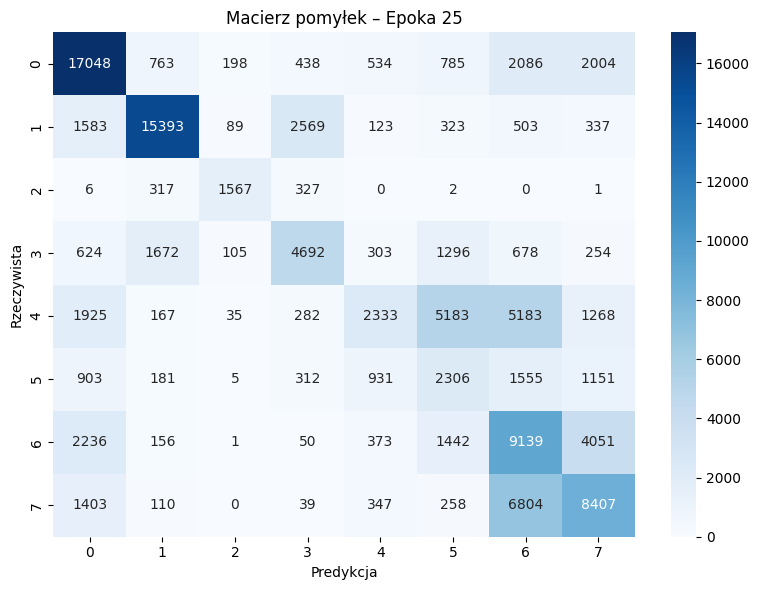

              precision    recall  f1-score   support

           0      0.663     0.715     0.688     23856
           1      0.821     0.736     0.776     20920
           2      0.783     0.706     0.743      2220
           3      0.539     0.488     0.512      9624
           4      0.472     0.142     0.219     16376
           5      0.199     0.314     0.244      7344
           6      0.352     0.524     0.421     17448
           7      0.481     0.484     0.483     17368

    accuracy                          0.529    115156
   macro avg      0.539     0.514     0.511    115156
weighted avg      0.552     0.529     0.524    115156


--- Epoka 26/30 ---


Epoka 26 [trening]:  12%|█▏        | 1527/12255 [13:07<1:13:24,  2.44it/s, loss=0.3443]

⚠️ Batch 1527: NaN loss – pominięto


Epoka 26 [walidacja]: 100%|██████████| 1800/1800 [04:50<00:00,  6.20it/s]


✅ Epoka 26 zakończona | Loss: 4270.1768 | Val ACC: 0.5117 | Czas: 1:50:19


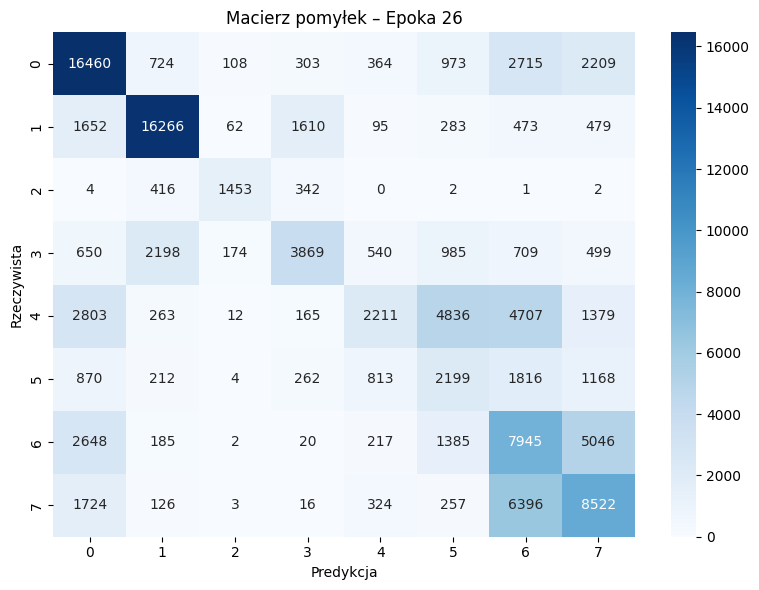

              precision    recall  f1-score   support

           0      0.614     0.690     0.650     23856
           1      0.798     0.778     0.788     20920
           2      0.799     0.655     0.720      2220
           3      0.587     0.402     0.477      9624
           4      0.484     0.135     0.211     16376
           5      0.201     0.299     0.241      7344
           6      0.321     0.455     0.376     17448
           7      0.441     0.491     0.465     17368

    accuracy                          0.512    115156
   macro avg      0.531     0.488     0.491    115156
weighted avg      0.534     0.512     0.504    115156


--- Epoka 27/30 ---


Epoka 27 [trening]:  70%|███████   | 8617/12255 [1:14:09<25:01,  2.42it/s, loss=0.3420]

⚠️ Batch 8617: NaN loss – pominięto


Epoka 27 [walidacja]: 100%|██████████| 1800/1800 [04:50<00:00,  6.20it/s]


✅ Epoka 27 zakończona | Loss: 4214.7727 | Val ACC: 0.5195 | Czas: 1:50:19


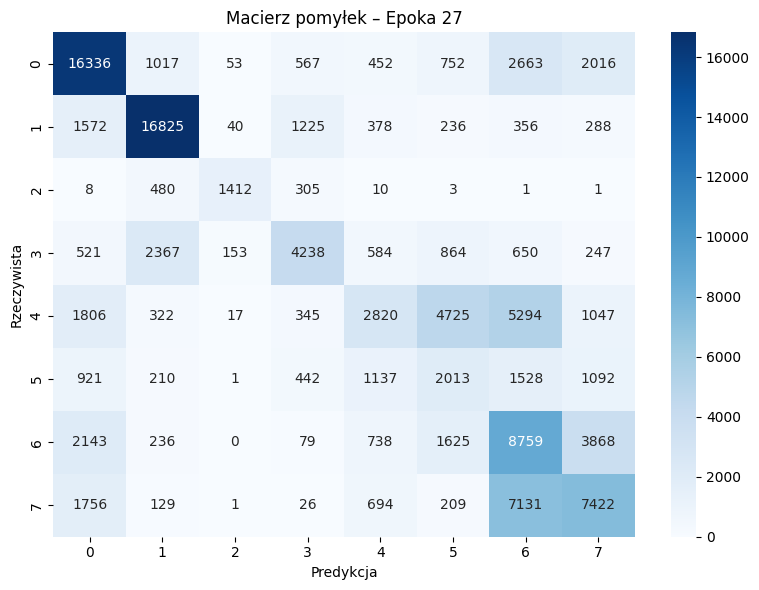

              precision    recall  f1-score   support

           0      0.652     0.685     0.668     23856
           1      0.779     0.804     0.792     20920
           2      0.842     0.636     0.725      2220
           3      0.586     0.440     0.503      9624
           4      0.414     0.172     0.243     16376
           5      0.193     0.274     0.227      7344
           6      0.332     0.502     0.400     17448
           7      0.464     0.427     0.445     17368

    accuracy                          0.520    115156
   macro avg      0.533     0.493     0.500    115156
weighted avg      0.533     0.520     0.515    115156


--- Epoka 28/30 ---


Epoka 28 [trening]:  21%|██        | 2590/12255 [22:16<1:08:09,  2.36it/s, loss=0.3359]

⚠️ Batch 2590: NaN loss – pominięto


Epoka 28 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.10it/s]


✅ Epoka 28 zakończona | Loss: 4173.9298 | Val ACC: 0.5253 | Czas: 1:51:42


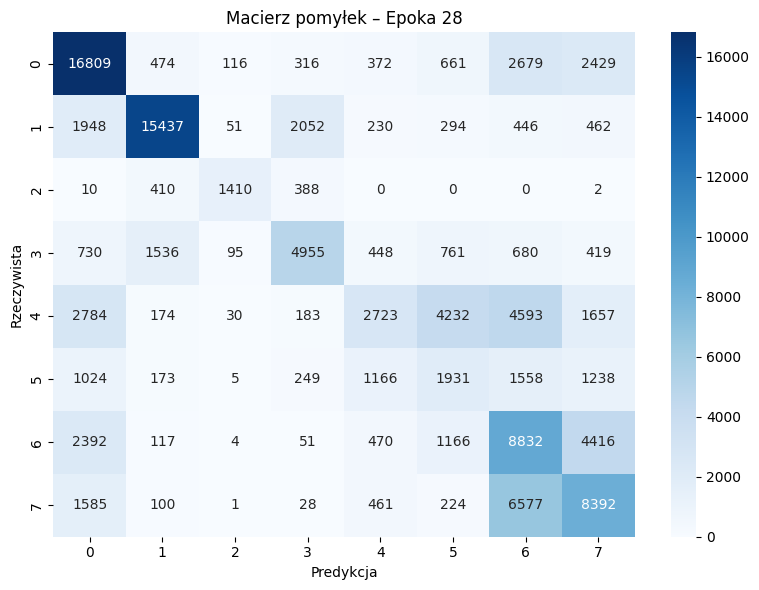

              precision    recall  f1-score   support

           0      0.616     0.705     0.657     23856
           1      0.838     0.738     0.785     20920
           2      0.824     0.635     0.717      2220
           3      0.603     0.515     0.555      9624
           4      0.464     0.166     0.245     16376
           5      0.208     0.263     0.232      7344
           6      0.348     0.506     0.413     17448
           7      0.441     0.483     0.461     17368

    accuracy                          0.525    115156
   macro avg      0.543     0.501     0.508    115156
weighted avg      0.545     0.525     0.521    115156


--- Epoka 29/30 ---


Epoka 29 [trening]:   8%|▊         | 1033/12255 [09:01<1:18:00,  2.40it/s, loss=0.3314]

⚠️ Batch 1033: NaN loss – pominięto


Epoka 29 [walidacja]: 100%|██████████| 1800/1800 [04:55<00:00,  6.10it/s]


✅ Epoka 29 zakończona | Loss: 4126.5301 | Val ACC: 0.5258 | Czas: 1:52:02


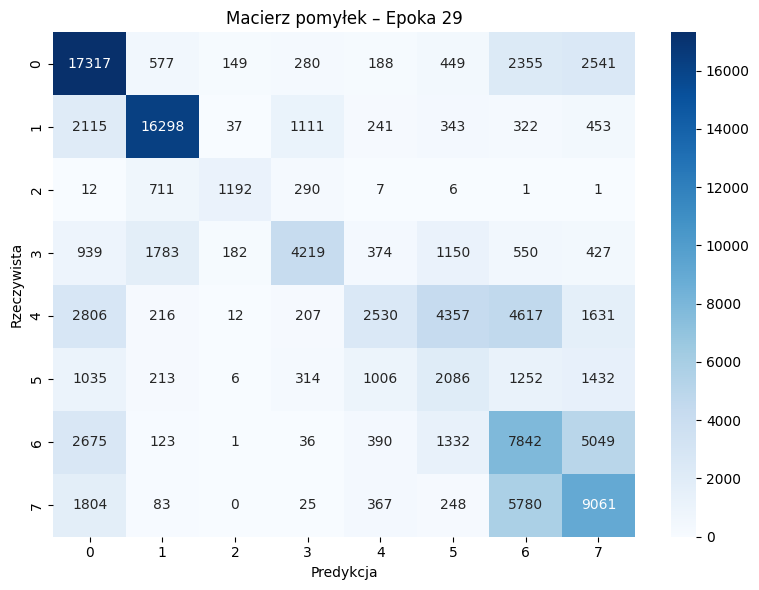

              precision    recall  f1-score   support

           0      0.603     0.726     0.659     23856
           1      0.815     0.779     0.797     20920
           2      0.755     0.537     0.628      2220
           3      0.651     0.438     0.524      9624
           4      0.496     0.154     0.236     16376
           5      0.209     0.284     0.241      7344
           6      0.345     0.449     0.390     17448
           7      0.440     0.522     0.477     17368

    accuracy                          0.526    115156
   macro avg      0.539     0.486     0.494    115156
weighted avg      0.544     0.526     0.517    115156


--- Epoka 30/30 ---


Epoka 30 [trening]:  33%|███▎      | 4029/12255 [35:11<57:08,  2.40it/s, loss=0.3274]  

⚠️ Batch 4029: NaN loss – pominięto


Epoka 30 [walidacja]: 100%|██████████| 1800/1800 [04:54<00:00,  6.11it/s]


✅ Epoka 30 zakończona | Loss: 4085.9241 | Val ACC: 0.5213 | Czas: 1:52:01


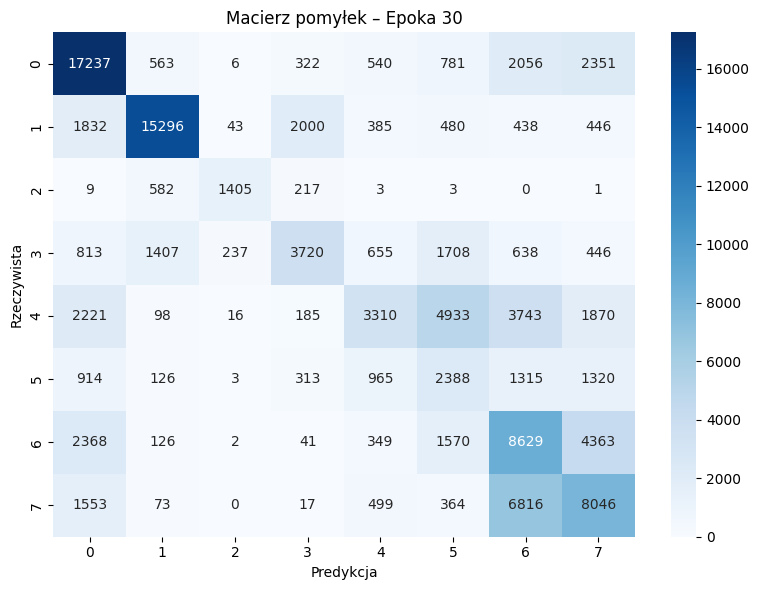

              precision    recall  f1-score   support

           0      0.640     0.723     0.679     23856
           1      0.837     0.731     0.781     20920
           2      0.821     0.633     0.715      2220
           3      0.546     0.387     0.453      9624
           4      0.494     0.202     0.287     16376
           5      0.195     0.325     0.244      7344
           6      0.365     0.495     0.420     17448
           7      0.427     0.463     0.444     17368

    accuracy                          0.521    115156
   macro avg      0.541     0.495     0.503    115156
weighted avg      0.548     0.521     0.521    115156



In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm
import time
from datetime import timedelta

# Urządzenie
print(f"Urządzenie: {device}")
if str(device) == "mps":
    print("OSTRZEŻENIE: Wykryto MPS (Apple GPU). Niektóre operacje jak FFT mogą być wolniejsze lub nieoptymalne.")

# Konwersja do tensorów – BEZ tworzenia kopii (oszczędność pamięci)
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()
X_val_tensor = torch.from_numpy(val).float()
y_val_tensor = torch.from_numpy(val_label).long()

# Dataset i DataLoader
train_dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=False)

# Model
model = TimesNet(configs).to(device)
print("✅ Model zainicjalizowany")

# Optymalizator i loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Trening
epochs = 30
best_acc = 0.0
best_epoch = -1
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"\n--- Epoka {epoch+1}/{epochs} ---")
    epoch_start = time.time()
    model.train()
    running_loss = 0.0

    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoka {epoch+1} [trening]")
    for batch_idx, (X_batch, y_batch) in train_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        x_enc = X_batch.permute(0, 2, 1)
        x_mark_enc = torch.zeros(x_enc.shape[0], x_enc.shape[1], 4).to(device)
        x_dec = torch.zeros_like(x_enc)
        x_mark_dec = torch.zeros(x_enc.shape[0], x_enc.shape[1], 4).to(device)

        try:
            outputs = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
            loss = criterion(outputs, y_batch)
            if torch.isnan(loss):
                train_bar.write(f"⚠️ Batch {batch_idx+1}: NaN loss – pominięto")
                continue
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            avg_loss = running_loss / (batch_idx + 1)
            train_bar.set_postfix(loss=f"{avg_loss:.4f}")
        except Exception as e:
            train_bar.write(f"Błąd batch {batch_idx+1}: {e}")
            continue

    train_losses.append(running_loss / len(train_loader))

    # === Walidacja ===
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoka {epoch+1} [walidacja]")
        for val_batch_idx, (X_batch, y_batch) in enumerate(val_bar):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            x_enc = X_batch.permute(0, 2, 1)
            x_mark_enc = torch.zeros(x_enc.shape[0], x_enc.shape[1], 4).to(device)
            x_dec = torch.zeros_like(x_enc)
            x_mark_dec = torch.zeros(x_enc.shape[0], x_enc.shape[1], 4).to(device)

            try:
                outputs = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
                _, preds = torch.max(outputs, 1)
                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
            except Exception as e:
                val_bar.write(f"❌ Walidacja batch {val_batch_idx+1} error: {e}")
                continue

    acc = accuracy_score(y_true, y_pred)
    val_accuracies.append(acc)

    # === Raport i wykresy ===
    print(f"✅ Epoka {epoch+1} zakończona | Loss: {running_loss:.4f} | Val ACC: {acc:.4f} | Czas: {timedelta(seconds=int(time.time() - epoch_start))}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Macierz pomyłek – Epoka {epoch+1}")
    plt.xlabel("Predykcja")
    plt.ylabel("Rzeczywista")
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true, y_pred, digits=3))

    # Zapis modelu
    if acc > best_acc:
        best_acc = acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_model.pth")
        print(f"💾 Zapisano nowy najlepszy model: epoka {best_epoch}, acc={best_acc:.4f}")


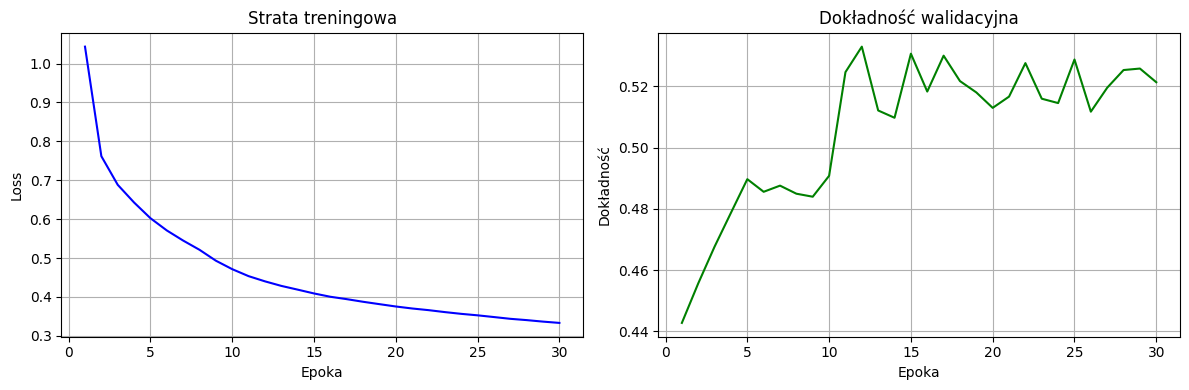

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Strata treningowa")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_accuracies, label="Val Accuracy", color='green')
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.title("Dokładność walidacyjna")
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
print(y)

[3 3 3 ... 4 4 4]
